In [1]:
# Cài đặt và Import thư viện
# Cài đặt và Import thư viện
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
import sys
from heapq import heappush, heappop

print("Các thư viện đã được import.")

Các thư viện đã được import.


In [2]:
# Đo thời gian tổng
start_time_total = time.time()

# Data Generation và Shingling
def generate_random_string(min_len, max_len):
    length = random.randint(min_len, max_len)
    return ''.join(random.choice(string.ascii_lowercase) for _ in range(length))

def get_shingles(text, k=4):
    shingles = set()
    if text is None or len(text) < k:
        return shingles
    for i in range(len(text) - k + 1):
        shingles.add(text[i:i+k])
    return shingles

# Thông số
NUM_TOTAL_STRINGS = 10000
MIN_LENGTH = 32
MAX_LENGTH = 64
SHINGLE_K = 4
CSV_FILENAME = "generated_strings_with_shingles.csv"
SAMPLE_SIZE_FOR_CLUSTERING = 10000  # Giảm để thử nghiệm, tăng lên 10000 sau khi tối ưu
NUM_FINAL_CLUSTERS_TARGET = 5

print("--- Bước 1: Tạo dữ liệu và Shingling ---")
start_time = time.time()
data_to_generate = []
for i in range(NUM_TOTAL_STRINGS):
    original_string = generate_random_string(MIN_LENGTH, MAX_LENGTH)
    shingles_set = get_shingles(original_string, k=SHINGLE_K)
    data_to_generate.append({
        "index": i,
        "string": original_string,
        "shingles": shingles_set
    })

df_generated_all = pd.DataFrame(data_to_generate)
df_to_save_csv = df_generated_all.copy()
df_to_save_csv['shingles'] = df_to_save_csv['shingles'].apply(lambda s: list(s))
df_to_save_csv.to_csv(CSV_FILENAME, index=False)
print(f"Đã tạo và lưu {len(df_generated_all)} chuỗi vào file '{CSV_FILENAME}'.")
print(f"Thời gian tạo dữ liệu: {time.time() - start_time:.2f} giây")
print("-" * 30)

--- Bước 1: Tạo dữ liệu và Shingling ---
Đã tạo và lưu 10000 chuỗi vào file 'generated_strings_with_shingles.csv'.
Thời gian tạo dữ liệu: 0.66 giây
------------------------------


In [3]:
#Jaccard Distance Function
# Yêu cầu: Dùng Jaccard distance để đo sự khác biệt
def jaccard_distance(set1, set2):
    if not isinstance(set1, set):
        set1 = set(set1)
    if not isinstance(set2, set):
        set2 = set(set2)
    intersection_len = len(set1.intersection(set2))
    union_len = len(set1.union(set2))
    if union_len == 0:
        return 1.0  # Đề yêu cầu 1.0 cho trường hợp rỗng
    return 1.0 - intersection_len / union_len

print("\n--- Bước 2: Định nghĩa hàm Jaccard Distance ---")
# Test nhỏ (có thể bỏ qua khi nộp bài)
set_a = {'a', 'b', 'c'}
set_b = {'b', 'c', 'd'}
print(f"Test Jaccard Distance (A, B): {jaccard_distance(set_a, set_b)}") # Expected: 0.5
set_c = {'x', 'y'}
print(f"Test Jaccard Distance (A, C): {jaccard_distance(set_a, set_c)}") # Expected: 1.0
print(f"Test Jaccard Distance (A, A): {jaccard_distance(set_a, set_a)}") # Expected: 0.0
print("-" * 30)


--- Bước 2: Định nghĩa hàm Jaccard Distance ---
Test Jaccard Distance (A, B): 0.5
Test Jaccard Distance (A, C): 1.0
Test Jaccard Distance (A, A): 0.0
------------------------------


In [4]:
class AgglomerativeHierarchicalClustering:
    def __init__(self, distance_metric_func):
        self.distance_metric = distance_metric_func
        self.samples_data = []
        self.clusters = []
        self.clustroids = {}
        self._distance_cache = {}  # Cache khoảng cách Jaccard

    def _get_cached_distance(self, idx1, idx2):
        key = tuple(sorted([idx1, idx2]))
        if key not in self._distance_cache:
            self._distance_cache[key] = self.distance_metric(self.samples_data[idx1], self.samples_data[idx2])
        return self._distance_cache[key]

    def _calculate_clustroid(self, cluster_member_indices, max_points_to_check=100):
        if not cluster_member_indices:
            return None
        if len(cluster_member_indices) == 1:
            return cluster_member_indices[0]
        indices_to_check = cluster_member_indices[:max_points_to_check] if len(cluster_member_indices) > max_points_to_check else cluster_member_indices
        min_total_dist_to_others = float('inf')
        best_clustroid_idx = -1
        for idx in indices_to_check:
            total_dist = sum(self._get_cached_distance(idx, other_idx)
                             for other_idx in cluster_member_indices if other_idx != idx)
            if total_dist < min_total_dist_to_others:
                min_total_dist_to_others = total_dist
                best_clustroid_idx = idx
        return best_clustroid_idx

    def _get_cluster_distance(self, cluster1_id_tuple, cluster2_id_tuple):
        clustroid1_idx = self.clustroids[cluster1_id_tuple]
        clustroid2_idx = self.clustroids[cluster2_id_tuple]
        return self._get_cached_distance(clustroid1_idx, clustroid2_idx)

    def fit(self, input_shingle_sets, num_target_clusters=None):
        start_time = time.time()
        self.samples_data = input_shingle_sets
        num_initial_samples = len(self.samples_data)
        self.clusters = [tuple([i]) for i in range(num_initial_samples)]
        self.clustroids = {tuple([i]): i for i in range(num_initial_samples)}

        if num_initial_samples == 0:
            return []

        # Sử dụng priority queue để tìm cặp gần nhất
        from heapq import heappush, heappop
        heap = []
        distances = {}  # Lưu khoảng cách giữa các cụm
        for i in range(len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                dist = self._get_cluster_distance(self.clusters[i], self.clusters[j])
                heappush(heap, (dist, i, j))
                distances[(i, j)] = dist

        current_iteration = 0
        while len(self.clusters) > num_target_clusters:
            current_iteration += 1
            if current_iteration % 100 == 0:
                print(f"Iteration {current_iteration}, Num clusters: {len(self.clusters)}")

            # Lấy cặp gần nhất từ heap
            while heap:
                dist, i, j = heappop(heap)
                if i < len(self.clusters) and j < len(self.clusters) and self.clusters[i] and self.clusters[j]:
                    break
            else:
                print("No valid pair to merge. Stopping.")
                break

            c1_id, c2_id = self.clusters[i], self.clusters[j]
            merged_indices = list(c1_id) + list(c2_id)
            new_cluster_id = tuple(sorted(merged_indices))
            new_clustroid_idx = self._calculate_clustroid(merged_indices)
            if new_clustroid_idx is None:
                print("Warning: Could not calculate clustroid. Stopping.")
                break

            self.clustroids[new_cluster_id] = new_clustroid_idx
            self.clusters.append(new_cluster_id)
            self.clusters[i] = None  # Đánh dấu để xóa
            self.clusters[j] = None
            self.clusters = [c for c in self.clusters if c is not None]
            del self.clustroids[c1_id]
            del self.clustroids[c2_id]

            # Cập nhật heap với khoảng cách từ cụm mới
            new_idx = len(self.clusters) - 1
            for k in range(len(self.clusters)):
                if k != new_idx and self.clusters[k]:
                    dist = self._get_cluster_distance(self.clusters[new_idx], self.clusters[k])
                    heappush(heap, (dist, min(new_idx, k), max(new_idx, k)))

        print(f"Thời gian phân cụm: {time.time() - start_time:.2f} giây")
        return self.clusters

    def get_final_cluster_details(self):
        detailed_clusters = []
        for cluster_id_tuple in self.clusters:
            shingles_in_this_cluster = [self.samples_data[idx] for idx in cluster_id_tuple]
            clustroid_idx = self.clustroids.get(cluster_id_tuple)
            clustroid_shingles = self.samples_data[clustroid_idx] if clustroid_idx is not None else None
            detailed_clusters.append({
                "member_original_indices": list(cluster_id_tuple),
                "member_shingle_sets": shingles_in_this_cluster,
                "clustroid_original_sample_index": clustroid_idx,
                "clustroid_shingles": clustroid_shingles
            })
        return detailed_clusters

print("\n--- Bước 2: Định nghĩa lớp AgglomerativeHierarchicalClustering ---")


--- Bước 2: Định nghĩa lớp AgglomerativeHierarchicalClustering ---



--- Bước 3: Đọc dữ liệu, Chạy AHC và Thí nghiệm ---
Đã đọc dữ liệu: 10000 mẫu
Thời gian đọc dữ liệu: 2.27 giây
Số mẫu phân cụm: 10000
Iteration 100, Num clusters: 9901
Iteration 200, Num clusters: 9801
Iteration 300, Num clusters: 9701
Iteration 400, Num clusters: 9601
Iteration 500, Num clusters: 9501
Iteration 600, Num clusters: 9401
Iteration 700, Num clusters: 9301
Iteration 800, Num clusters: 9201
Iteration 900, Num clusters: 9101
Iteration 1000, Num clusters: 9001
Iteration 1100, Num clusters: 8901
Iteration 1200, Num clusters: 8801
Iteration 1300, Num clusters: 8701
Iteration 1400, Num clusters: 8601
Iteration 1500, Num clusters: 8501
Iteration 1600, Num clusters: 8401
Iteration 1700, Num clusters: 8301
Iteration 1800, Num clusters: 8201
Iteration 1900, Num clusters: 8101
Iteration 2000, Num clusters: 8001
Iteration 2100, Num clusters: 7901
Iteration 2200, Num clusters: 7801
Iteration 2300, Num clusters: 7701
Iteration 2400, Num clusters: 7601
Iteration 2500, Num clusters: 7501

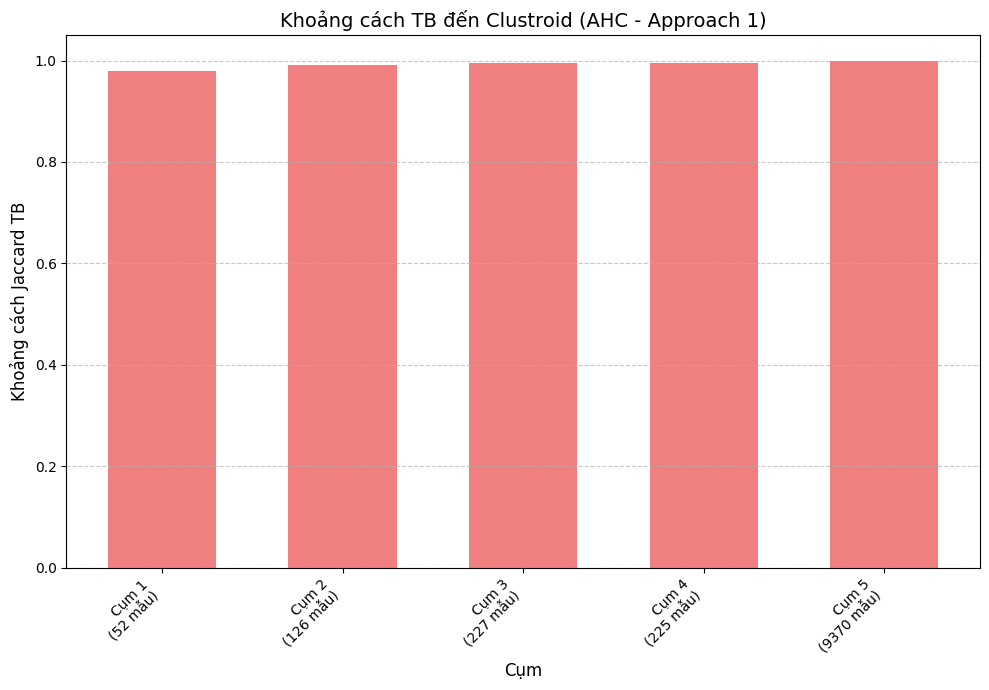

Thời gian thí nghiệm: 0.88 giây
Tổng thời gian: 2317.62 giây
Hoàn thành Task 1.


In [5]:
print("\n--- Bước 3: Đọc dữ liệu, Chạy AHC và Thí nghiệm ---")
start_time = time.time()
try:
    df_input_data = pd.read_csv(CSV_FILENAME)
except FileNotFoundError:
    print(f"LỖI: File '{CSV_FILENAME}' không tìm thấy.")
    raise SystemExit

df_input_data['shingles'] = df_input_data['shingles'].apply(lambda x: set(ast.literal_eval(x)))
print(f"Đã đọc dữ liệu: {len(df_input_data)} mẫu")
print(f"Thời gian đọc dữ liệu: {time.time() - start_time:.2f} giây")

if SAMPLE_SIZE_FOR_CLUSTERING < len(df_input_data):
    df_for_clustering = df_input_data.sample(n=SAMPLE_SIZE_FOR_CLUSTERING, random_state=42).reset_index(drop=True)
else:
    df_for_clustering = df_input_data.reset_index(drop=True)

list_of_shingle_sets_for_clustering = df_for_clustering['shingles'].tolist()
print(f"Số mẫu phân cụm: {len(list_of_shingle_sets_for_clustering)}")

# Chạy AHC
ahc_model = AgglomerativeHierarchicalClustering(distance_metric_func=jaccard_distance)
final_clusters = ahc_model.fit(list_of_shingle_sets_for_clustering, num_target_clusters=NUM_FINAL_CLUSTERS_TARGET)
final_clusters_info = ahc_model.get_final_cluster_details()
print(f"Số cụm cuối: {len(final_clusters_info)}")

# Tính khoảng cách trung bình
start_time = time.time()
avg_dist_to_clustroid_per_cluster = []
cluster_sizes_for_plotting = []
for cluster_idx, cluster_data in enumerate(final_clusters_info):
    clustroid_shingles = cluster_data['clustroid_shingles']
    member_shingles = cluster_data['member_shingle_sets']
    if not member_shingles or clustroid_shingles is None:
        avg_dist_to_clustroid_per_cluster.append(0)
        cluster_sizes_for_plotting.append(0)
        continue
    total_dist = sum(jaccard_distance(member, clustroid_shingles) for member in member_shingles)
    num_members = len(member_shingles)
    avg_dist = total_dist / num_members if num_members > 0 else 0
    avg_dist_to_clustroid_per_cluster.append(avg_dist)
    cluster_sizes_for_plotting.append(num_members)
    print(f"Cụm {cluster_idx+1}: Khoảng cách TB = {avg_dist:.4f}, Số mẫu = {num_members}")

# Vẽ biểu đồ
if avg_dist_to_clustroid_per_cluster:
    plt.figure(figsize=(10, 7))
    bar_labels = [f'Cụm {i+1}\n({cluster_sizes_for_plotting[i]} mẫu)' for i in range(len(avg_dist_to_clustroid_per_cluster))]
    plt.bar(bar_labels, avg_dist_to_clustroid_per_cluster, color='lightcoral', width=0.6)
    plt.xlabel("Cụm", fontsize=12)
    plt.ylabel("Khoảng cách Jaccard TB", fontsize=12)
    plt.title(f"Khoảng cách TB đến Clustroid (AHC - Approach 1)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
print(f"Thời gian thí nghiệm: {time.time() - start_time:.2f} giây")

print(f"Tổng thời gian: {time.time() - start_time_total:.2f} giây")
print("Hoàn thành Task 1.")